# Analyze Results from r/ffxiv Study
J. Nathan Matias, July 2020

The [pre-analysis plan for this study](https://osf.io/ymv9h/) is on the open science framework.

## Codebook

### Posts
* **newcomer.comments**: the number of first-time comments
* **newcomer.comments.removed** : number of first-time comments removed
* **num.comments**: total number of comments
* **num.comments.removed**: total number of removed comments
* **num.commenters**: number of unique accounts commenting in the discussion
* **visible**: whether the post was allowed by human or automated moderators to remain in the community
* **weekend (0/1)**: whether the post was created on a weekend or not
* **weekday (0-6)**: the day of the week (Monday =0 ) that the post was published (see [Python datetime](https://docs.python.org/2/library/datetime.html))
* **block.id**: Randomization block ID
* **treatment (0/1)**: Whether the post received the treatment 

### Newcomer comments
The dataset of comments are comments from accounts that had not made a comment in the previous 6 months.

* **visible (0/1)**: whether the comment was permitted by moderators to be shown (1), or whether it was removed (0)
* **post.block.id**: randomization block that the post was in
* **post.treatment (0/1)**: whether the toplevel post was in the treatment group or not
* **post.assign.number**: unique integer assigned to the post within our experiment. Multiple comments will have the same number, since many posts received more than one newcomer comment
* **post.visible**: binary indicator for whether the post was permitted by moderators
* **minutes.since.post.created**: the number of minutes elapsed between post creation and comment submission
* **body.length**: the number of characters in the comment
* **is_submitter**: whether the commenter is the person who submitted the top level discussion post
* **author.prev.comments**: number of previous comments made by the account (should always be 0 for the newcomers dataset)


## Load Libraries and Files

In [171]:
data.dir = "~/Tresors/CivilServant/projects/CivilServant-reddit/r-ffxiv-2020"
newcomer.comments.filename = "r-ffxiv-newcomer-comments-11.22.2020.csv"
all.comments.filename = "r-ffxiv-all-comments-11.22.2020.csv"
posts.filename = "r-ffxiv-posts-11.22.2020.csv"

In [192]:
library(gmodels)  # Contains CrossTable
library(estimatr) # Contains difference_in_means
library(MASS)     # Contains glm.nb
library(rms)      # Contains lrm

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")

bg.whiteortransparent <- Sys.getenv('RTRANSPARENTBG','white')


cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]),
                    plot.background = element_rect(fill =bg.whiteortransparent, color = NA), # bg of the plot
                   )

In [281]:
comments.df <- read.csv(file.path(data.dir, comments.filename))
comments.df$visible <- as.numeric(comments.df$visible=="True")
posts.df    <- read.csv(file.path(data.dir, posts.filename))

all.comments.df <- read.csv(file.path(data.dir, all.comments.filename))
all.comments.df$visible <- as.numeric(all.comments.df$visible=="True")


In [282]:
head(comments.df)

author.prev.comments,body.length,is_submitter,link_id,minutes.since.post.created,newcomer,post.assign.number,post.block.id,post.treatment,post.visible,subreddit_id,visible,weekend
0,11,True,t3_c9vf2u,8.766667,True,8,block00002,0,True,t5_2rgs7,1,False
0,54,True,t3_c9vct6,31.333333,True,2,block00001,1,True,t5_2rgs7,1,False
0,351,True,t3_c9vggh,271.233333,True,10,block00002,1,True,t5_2rgs7,1,False
0,167,False,t3_c9vo29,13.700000,True,16,block00003,0,True,t5_2rgs7,1,False
0,204,False,t3_c9vc2f,58.500000,True,4,block00001,0,True,t5_2rgs7,1,False
0,76,True,t3_c9vz0e,15.833333,True,25,block00005,0,True,t5_2rgs7,1,False


In [283]:
head(all.comments.df)

author.prev.comments,body.length,is_submitter,link_id,minutes.since.post.created,newcomer,post.assign.number,post.block.id,post.treatment,post.visible,subreddit_id,visible,weekend
63,37,False,t3_c9va6o,0.600000,False,5,block00001,1,True,t5_2rgs7,1,False
273,5,False,t3_c9va6o,0.900000,False,5,block00001,1,True,t5_2rgs7,1,False
1154,106,False,t3_c9va6o,1.466667,False,5,block00001,1,True,t5_2rgs7,1,False
3,291,True,t3_c9va6o,5.666667,False,5,block00001,1,True,t5_2rgs7,1,False
372,3,False,t3_c9va6o,7.633333,False,5,block00001,1,True,t5_2rgs7,1,False
1385,62,False,t3_c9vda9,0.500000,False,1,block00001,0,False,t5_2rgs7,1,False


In [176]:
head(posts.df)

block.id,created,newcomer.comments,newcomer.comments.removed,num.commenters,num.comments,num.comments.removed,treatment,visible,weekday,weekend
block01039,2019-07-25 22:33:59,6,1,102,197,5,0,True,3,False
block00609,2019-07-14 14:55:39,0,0,14,15,1,1,True,6,True
block00152,2019-07-08 04:40:04,0,0,4,4,0,0,False,0,False
block01969,2019-08-22 01:50:22,0,0,6,9,0,1,False,3,False
block00430,2019-07-11 18:51:52,0,0,4,4,0,0,True,3,False
block01646,2019-08-11 16:15:46,0,0,2,2,0,1,True,6,True


# Drop unbalanced randomization blocks

In [284]:
posts.df$counter <- 1
block.counts <- aggregate(posts.df[c("counter")], by=list(posts.df$block.id), FUN=sum)
unbalanced.blocks <- subset(block.counts, counter<6)$Group.1

## remove all posts in unbalanced blocks
posts.df <- subset(posts.df, (block.id %in% unbalanced.blocks)!=TRUE)

## remove all comments in unbalanced blocks
comments.df <- subset(comments.df, (post.block.id %in% unbalanced.blocks)!=TRUE)
all.comments.df <- subset(all.comments.df, (post.block.id %in% unbalanced.blocks)!=TRUE)

In [285]:
nrow(posts.df)
nrow(comments.df)
nrow(all.comments.df)

[1] 12096

[1] 12362

[1] 345313

# Summary Statistics

In [181]:
summary(factor(posts.df$treatment))

0    1 
6048 6048

In [182]:
summary(factor(posts.df$visible))

False  True 
 1092 11004

In [183]:
summary(factor(posts.df$weekend))

False  True 
10301  1795

In [184]:
summary(factor(comments.df$post.treatment))

0    1 
6336 6026

In [185]:
summary(factor(comments.df$visible))

0     1 
  161 12201

In [186]:
summary(factor(all.comments.df$visible))

False   True 
  2312 343075

In [187]:
summary(factor(all.comments.df$newcomer))

False   True 
333022  12365

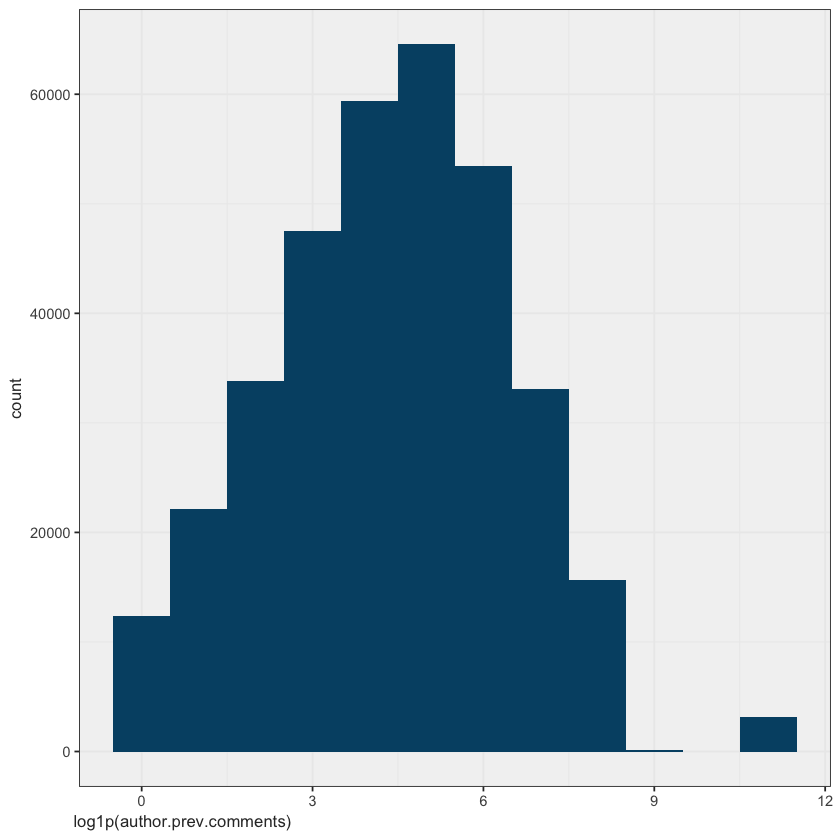

In [198]:
ggplot(all.comments.df, aes(log1p(author.prev.comments))) +
    geom_histogram(binwidth=1, fill=catpalette[3]) +
    cat.theme

# Main Findings

In [287]:
summary(m.post.new <- glm.nb(newcomer.comments ~ treatment, data=posts.df))
summary(m.post.new.removed <- glm.nb(newcomer.comments.removed ~ treatment, data=posts.df))


Call:
glm.nb(formula = newcomer.comments ~ treatment, data = posts.df, 
    init.theta = 0.2858542295, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9383  -0.9383  -0.9263   0.0017   9.3186  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.04652    0.02713   1.714   0.0864 .
treatment   -0.05016    0.03848  -1.304   0.1923  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.2859) family taken to be 1)

    Null deviance: 9222.7  on 12095  degrees of freedom
Residual deviance: 9221.0  on 12094  degrees of freedom
AIC: 30909

Number of Fisher Scoring iterations: 1


              Theta:  0.28585 
          Std. Err.:  0.00638 

 2 x log-likelihood:  -30902.76300 


Call:
glm.nb(formula = newcomer.comments.removed ~ treatment, data = posts.df, 
    init.theta = 0.01734774544, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.1415  -0.1415  -0.1396  -0.1396   3.8702  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.33804    0.14896 -29.122   <2e-16 ***
treatment    0.03727    0.20956   0.178    0.859    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0173) family taken to be 1)

    Null deviance: 486.03  on 12095  degrees of freedom
Residual deviance: 486.00  on 12094  degrees of freedom
AIC: 1518.7

Number of Fisher Scoring iterations: 1


              Theta:  0.01735 
          Std. Err.:  0.00328 

 2 x log-likelihood:  -1512.70600 

In [288]:
## We didn't anticipate that difference in means couldn't handle blocks of different sizes
## so we use lm_robust from the estimatr package

summary(
    m.newcomer.visible <- lm_robust(visible ~ post.treatment, data=comments.df,
          clusters=comments.df$post.assign.number)
    )


Call:
lm_robust(formula = visible ~ post.treatment, data = comments.df, 
    clusters = comments.df$post.assign.number)

Standard error type:  CR2 

Coefficients:
                Estimate Std. Error  t value Pr(>|t|)  CI Lower CI Upper    DF
(Intercept)     0.987532   0.002230 442.9099   0.0000  0.983142 0.991921 270.1
post.treatment -0.001139   0.002863  -0.3979   0.6908 -0.006761 0.004483 669.2

Multiple R-squared:  2.523e-05 ,	Adjusted R-squared:  -5.568e-05 
F-statistic: 0.1583 on 1 and 4602 DF,  p-value: 0.6907

# Exploratory Questions

In [289]:
## Effect on the number of comments
summary(m.post.num.comments <- glm.nb(num.comments ~ treatment + weekend, data=posts.df))


posts.df$num.experienced.comments <- posts.df$num.comments - posts.df$newcomer.comments
summary(m.post.num.exp.comments <- glm.nb(num.experienced.comments ~ treatment + weekend, data=posts.df))


Call:
glm.nb(formula = num.comments ~ treatment + weekend, data = posts.df, 
    init.theta = 0.5175270953, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0569  -1.0725  -0.6835  -0.2171   9.8061  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.41203    0.01880 181.503  < 2e-16 ***
treatment   -0.06828    0.02551  -2.677  0.00744 ** 
weekendTrue -0.19701    0.03592  -5.484 4.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.5175) family taken to be 1)

    Null deviance: 14611  on 12095  degrees of freedom
Residual deviance: 14575  on 12093  degrees of freedom
AIC: 101777

Number of Fisher Scoring iterations: 1


              Theta:  0.51753 
          Std. Err.:  0.00592 

 2 x log-likelihood:  -101769.10400 


Call:
glm.nb(formula = num.experienced.comments ~ treatment + weekend, 
    data = posts.df, init.theta = 0.5087677444, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0349  -1.0493  -0.6943  -0.2093   9.7853  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.37662    0.01896 178.065  < 2e-16 ***
treatment   -0.06898    0.02573  -2.681  0.00734 ** 
weekendTrue -0.20272    0.03624  -5.594 2.22e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.5088) family taken to be 1)

    Null deviance: 14605  on 12095  degrees of freedom
Residual deviance: 14568  on 12093  degrees of freedom
AIC: 100708

Number of Fisher Scoring iterations: 1


              Theta:  0.50877 
          Std. Err.:  0.00583 

 2 x log-likelihood:  -100700.07200 

### Correlate rates of norm compliance with how many previous comments someone had made

In [290]:
# ggplot(all.comments.df, aes(visible, log1p(author.prev.comments), fill=visible)) +
#     geom_violin() +
#     cat.theme

In [291]:
all.comments.df$author.prev.comments.log1p <- log1p(all.comments.df$author.prev.comments)


In [292]:
summary(all.comments.df$visible)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9933  1.0000  1.0000 

In [310]:
m.comments.prev.visible <- lm_robust(visible ~ author.prev.comments.log1p, 
                                     data=subset(all.comments.df, post.treatment==0),
                                     clusters=subset(all.comments.df, post.treatment==0)$post.assign.number)
m.comments.prev.visible

                               Estimate   Std. Error    t value     Pr(>|t|)
(Intercept)                0.9911616847 0.0010164587 975.112586 0.0000000000
author.prev.comments.log1p 0.0005879413 0.0001752323   3.355211 0.0009021559
                               CI Lower     CI Upper       DF
(Intercept)                0.9891624194 0.9931609500 343.5666
author.prev.comments.log1p 0.0002430073 0.0009328753 281.1085

In [298]:
m.comments.newcomer.visible <- lm_robust(visible ~ newcomer, 
                                     data=subset(all.comments.df, post.treatment==0),
                                     clusters=subset(all.comments.df, post.treatment==0)$post.assign.number)
m.comments.newcomer.visible

                 Estimate   Std. Error     t value    Pr(>|t|)    CI Lower
(Intercept)   0.993978562 0.0004364559 2277.385852 0.000000000  0.99312053
newcomerTrue -0.006446996 0.0020948558   -3.077537 0.002297246 -0.01057093
                CI Upper       DF
(Intercept)   0.99483659 400.1912
newcomerTrue -0.00232306 275.8383

# Adjust P Values

In [297]:
## create a dataframe 
pvalue.dataframe <- function(model.object, model.name, coefficient="treatment"){
    
    if('Pr(>|t|)' %in% colnames(summary(model.object)$coefficients)){
        p.col = 'Pr(>|t|)'
    }else{
        p.col = 'Pr(>|z|)'
    }
#    print(coefficient)
#    print(p.col)
   return(data.frame("model"=model.name, 
                     "pvalue" = summary(model.object)$coefficients[coefficient,][[p.col]]))
}

In [305]:
## dataframe for storing p-values
p.values.confirmatory <- data.frame("model"=character(),  "p.value"= double(), "adjusted.value"=double())
p.values.all <- data.frame("model"=character(),  "p.value"= double(), "adjusted.value"=double())

p.values.confirmatory <- rbind(p.values.confirmatory,
                               pvalue.dataframe(m.post.new, "m.post.new"))
p.values.confirmatory <- rbind(p.values.confirmatory,
                               pvalue.dataframe(m.post.new.removed, "m.post.new.removed"))
p.values.confirmatory <- rbind(p.values.confirmatory,
                               pvalue.dataframe(m.newcomer.visible, "m.newcomer.visible", "post.treatment"))


In [306]:
p.values.confirmatory

model,pvalue
m.post.new,0.1923410
m.post.new.removed,0.8588369
m.newcomer.visible,0.6908380


In [311]:
p.values.all <- rbind(p.values.confirmatory, 
                      pvalue.dataframe(m.post.num.comments, "m.post.num.comments"))
p.values.all <- rbind(p.values.all,
                      pvalue.dataframe(m.post.num.exp.comments, "m.post.num.exp.comments"))
p.values.all <- rbind(p.values.all,
                      pvalue.dataframe(m.comments.prev.visible, "m.comments.prev.visible", "author.prev.comments.log1p"))
p.values.all <- rbind(p.values.all,
                      pvalue.dataframe(m.comments.newcomer.visible, "m.comments.newcomer.visible", "newcomerTrue"))

In [313]:
p.values.confirmatory

model,pvalue
m.post.new,0.1923410
m.post.new.removed,0.8588369
m.newcomer.visible,0.6908380


In [314]:
p.values.all

model,pvalue
m.post.new,0.1923409745
m.post.new.removed,0.8588368713
m.newcomer.visible,0.6908380302
m.post.num.comments,0.0074355651
m.post.num.exp.comments,0.0073399240
m.comments.prev.visible,0.0009021559
m.comments.newcomer.visible,0.0022972455
